In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pytz
from dateutil import tz
import os
import patsy #for spline regression
import scipy #for non-negative least square 
import scipy as sp 
from scipy import stats
from scipy.optimize import nnls
from numpy.linalg import inv #for matrix and statistics
import scipy as sp
import math
import statsmodels.api as sm
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
import sklearn.cluster
import sklearn.linear_model
import matplotlib.pyplot as plt
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
import pylab

%matplotlib inline

In [2]:
#Load data first

In [3]:
#specify data source 
#datasource = 'PJM'
#filename = 'pjm_e_load_data_2012.csv'
#datasource = 'CAISO/raw/caiso_load_data_2013'
datasource = 'CAISO/raw/caiso_load_data_2014'
#filename = 'caiso_north_load_data_2012.csv'

#timezone for local time adjustment
localtz = 'US/Pacific'

#specific to CAISO data
TacName = 'Caiso_Totals'#'TAC_NORTH'

In [4]:
mainDir = 'C:\Users\Admin\Dropbox\Active\EnergyProject\Thesis'
dataDir = mainDir + '/data/load/' + datasource +'/'
#outputDir = mainDir + '/output/'+ datasource +'/'

In [5]:
d01 = pd.read_csv(dataDir +'/'+ '01.csv')
d01 = d01[d01['TAC_ZONE_NAME']==TacName].sort(columns='INTERVALSTARTTIME_GMT')
d02 = pd.read_csv(dataDir +'/'+ '02.csv')
d02 = d02[d02['TAC_ZONE_NAME']==TacName].sort(columns='INTERVALSTARTTIME_GMT')
d03 = pd.read_csv(dataDir +'/'+ '03.csv')
d03 = d03[d03['TAC_ZONE_NAME']==TacName].sort(columns='INTERVALSTARTTIME_GMT')
d04 = pd.read_csv(dataDir +'/'+ '04.csv')
d04 = d04[d04['TAC_ZONE_NAME']==TacName].sort(columns='INTERVALSTARTTIME_GMT')
d05 = pd.read_csv(dataDir +'/'+ '05.csv')
d05 = d05[d05['TAC_ZONE_NAME']==TacName].sort(columns='INTERVALSTARTTIME_GMT')
d06 = pd.read_csv(dataDir +'/'+ '06.csv')
d06 = d06[d06['TAC_ZONE_NAME']==TacName].sort(columns='INTERVALSTARTTIME_GMT')
d07 = pd.read_csv(dataDir +'/'+ '07.csv')
d07 = d07[d07['TAC_ZONE_NAME']==TacName].sort(columns='INTERVALSTARTTIME_GMT')
d08 = pd.read_csv(dataDir +'/'+ '08.csv')
d08 = d08[d08['TAC_ZONE_NAME']==TacName].sort(columns='INTERVALSTARTTIME_GMT')
d09 = pd.read_csv(dataDir +'/'+ '09.csv')
d09 = d09[d09['TAC_ZONE_NAME']==TacName].sort(columns='INTERVALSTARTTIME_GMT')
d10 = pd.read_csv(dataDir +'/'+ '10.csv')
d10 = d10[d10['TAC_ZONE_NAME']==TacName].sort(columns='INTERVALSTARTTIME_GMT')
d11 = pd.read_csv(dataDir +'/'+ '11.csv')
d11 = d11[d11['TAC_ZONE_NAME']==TacName].sort(columns='INTERVALSTARTTIME_GMT')
d12 = pd.read_csv(dataDir +'/'+ '12.csv')
d12 = d12[d12['TAC_ZONE_NAME']==TacName].sort(columns='INTERVALSTARTTIME_GMT')

In [6]:
data = pd.concat([d01,d02,d03,d04,d05,d06,d07,d08,d09,d10,d11,d12])

In [7]:
data['tsLocal'] = data['INTERVALSTARTTIME_GMT'].map(lambda x: datetime.datetime.strptime(x[0:19],"%Y-%m-%dT%H:%M:%S").replace(tzinfo=pytz.utc)\
                            .astimezone(pytz.timezone(localtz)).strftime("%Y-%m-%d %H:%M:%S"))
data['tsLocal'] = data['tsLocal'].map(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))


In [8]:
data = data[['tsLocal','MW']].reset_index().drop(['index'],1)
data.columns = ['tsLocal','load']
#delete double readings (can happen due to daylight savings)
data = data.groupby(['tsLocal']).mean().reset_index()
loaddata = data

## Scope and load integration

In [9]:
#specify scope
StartScopeDate = '2014-01-01'
EndScopeDate = '2015-01-01'
StartScopeTime =  datetime.datetime.strptime(StartScopeDate,"%Y-%m-%d")
EndScopeTime =  datetime.datetime.strptime(EndScopeDate,"%Y-%m-%d")

#Generate data frame from start to end for time series
tslist = []
nxt = StartScopeTime
while nxt < EndScopeTime:
    tslist.append(nxt)
    nxt += datetime.timedelta(minutes=15)
    
Scope = pd.DataFrame(0, index = np.arange(len(tslist)), columns = ['tsLocal'])
Scope['tsLocal'] = tslist

#Now we can merge using Scope Table as a backbone of data structure.
d = pd.merge(Scope,loaddata,on=['tsLocal'], how = 'left') 

In [10]:
#Interpolate load values to 15 mins
for j in range(1,2):
    for i in range(0,d.shape[0]/4-1):
        if (type(d.iloc[4*i,j])!=pd.tslib.NaTType) & (type(d.iloc[4*(i+1),j])!=pd.tslib.NaTType):
            #d.iloc[4*(i+1),1]=float('NaN')
            d.iloc[4*i+1,j] = 0.75*d.iloc[4*i,j]+0.25*d.iloc[4*(i+1),j]
            d.iloc[4*i+2,j] = 0.50*d.iloc[4*i,j]+0.50*d.iloc[4*(i+1),j]
            d.iloc[4*i+3,j] = 0.25*d.iloc[4*i,j]+0.75*d.iloc[4*(i+1),j]

##PV output reading and integration 

In [11]:
[zipcode, PVcurve_shift] = ['92562',0.0862]
datasource = 'L'
#mainDir = 'C:/Users/umnouyp/Dropbox/Active/EnergyProject/Thesis/PVreadingsStudies/main'
#mainDir = 'C:/Users/Tee/Dropbox/Active/EnergyProject/Thesis/PVreadingsStudies/main'
mainDir = 'C:\Users\Admin\Dropbox\Active\EnergyProject\Thesis'
#we can choose which data to look at.
dataDir = mainDir + '/data/solar/' + datasource +'/' + zipcode +'/'
outputDir = mainDir + '/output/'+ datasource +'/' + zipcode +'/'
data = pd.read_csv(dataDir + '/training_data_fitted_adjusted.csv')

In [12]:
if type(data.tsLocal[0])==str:
    data['tsLocal'] = data['tsLocal'].map(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))

In [13]:
#if pass 02_07p, then it is already adjusted and rewritten
#Adjust to guarantee maximum
#data['mpower'] = data['mpower'] + PVcurve_shift

In [14]:
data[:1]

,tsLocal,altitude,azimuth,power,numactivecomp,totalsize,s,DBW,mpower,r,expectedr
0,2013-01-01 07:00:00,0.772319,-298.174761,NaN,2,13.528266,-0.999883,-355,0.264652,NaN,0.706748


In [15]:
#if pass 02_07p, then performance ratio is already calculated
#define performance ratio no need for shift anymore
#data['r'] = data.power/data.mpower

In [16]:
#Now we can merge using Scope Table as a backbone of data structure.
d = pd.merge(d,data,on=['tsLocal'], how = 'left') 

In [17]:
#Area under max power curve and expected power curve in MWh
np.sum(d['mpower'])*15/60/1000,np.sum(d['mpower']*d['expectedr'])*15/60/1000

(2.9312143325898243, 2.2866312819855796)

(0, 1440)

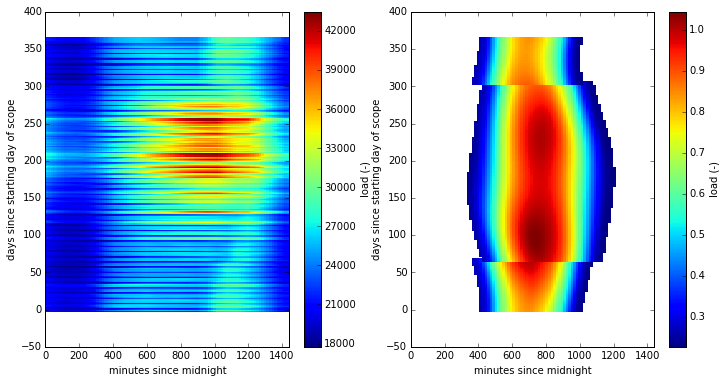

In [18]:
Ref = d.tsLocal.iloc[0].date()
x = d.tsLocal.map(lambda x: x.hour*60 + x.minute)
y = d.tsLocal.map(lambda x: (x.date()-Ref).days)
plt.clf()
fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_subplot(121)
#plt.subplot(2, 2, 1)

#plt.title('pcolor')
# set the limits of the plot to the limits of the data
#plt.axis([x.min(), x.max(), y.min(), y.max()])
#plt.colorbar()
maxload = np.max(d['load'])
#plt.pcolor(x, y, c=d['load'], cmap='RdBu', vmin=-maxload,vmax= maxload)
#color adjust with white = 0
#plt.scatter(x, y, c= d['load'], cmap = 'RdBu',edgecolors='none',marker=',',s=20, vmin=-maxload,vmax= maxload)
#color no-adjust
plt.scatter(x, y, c= d['load'],edgecolors='none',marker=',',s=20)
ax1.set_xlabel('minutes since midnight')
ax1.set_ylabel('days since starting day of scope')
cbar = plt.colorbar(ax=ax1)
cbar.ax.set_ylabel('load (-)')
ax1.set_xlim(0,1440)

ax1 = fig.add_subplot(122)
#plt.subplot(2, 2, 1)

#plt.title('pcolor')
# set the limits of the plot to the limits of the data
#plt.axis([x.min(), x.max(), y.min(), y.max()])
#plt.colorbar()
maxload = np.max(d['mpower'])
#plt.pcolor(x, y, c=d['load'], cmap='RdBu', vmin=-maxload,vmax= maxload)
#color adjust with white = 0
#plt.scatter(x, y, c= d['load'], cmap = 'RdBu',edgecolors='none',marker=',',s=20, vmin=-maxload,vmax= maxload)
#color no-adjust
plt.scatter(x, y, c= d['mpower'],edgecolors='none',marker=',',s=20)
ax1.set_xlabel('minutes since midnight')
ax1.set_ylabel('days since starting day of scope')
cbar = plt.colorbar(ax=ax1)
cbar.ax.set_ylabel('load (-)')
ax1.set_xlim(0,1440)

#PV penetration

In [19]:
maxload = np.max(d['load'])
totaldemand = np.sum(d['load'])

def quick_penetration(i):
    
    d['solar'] = d['mpower']*maxload*i/100
    d['solar'][d['mpower'].isnull()] = 0
    d['netload'] = d['load'] - d['solar']
    #d['check'] = d['netload'].map(lambda x: x<0)*maxload
    d['check'] = 1-d['netload'].map(lambda x: x<0)#*maxload
    effectivedemand = np.sum(d['netload'][d['netload']>0])
    effectivecontribution = 1 - effectivedemand/totaldemand
    idealcontribution = np.sum(d['solar'])/totaldemand
    
    #Investigate all instances before it goes higher than 100%
    d['SolarRatio'] = d['solar']/d['load']
    if np.sum(d['SolarRatio']>1.0)>0:
        l = d['SolarRatio'][d[d['SolarRatio']>1.0].index-1]
        #l = l[l<1.0]
        triggerratio = np.min(l)
    else:
        triggerratio = 1.0
    return effectivecontribution, idealcontribution, triggerratio;
    
    print effectivecontribution, idealcontribution, triggerratio
    
    

In [20]:
#remove plot from the function first
effective_c = [0]*100;
ideal_c = [0]*100;
trigger_r = [0]*100;
for i in range(100):
    effective_c[i], ideal_c[i], trigger_r[i] = quick_penetration(i);

C:\Users\Admin\Anaconda\lib\site-packages\IPython\kernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


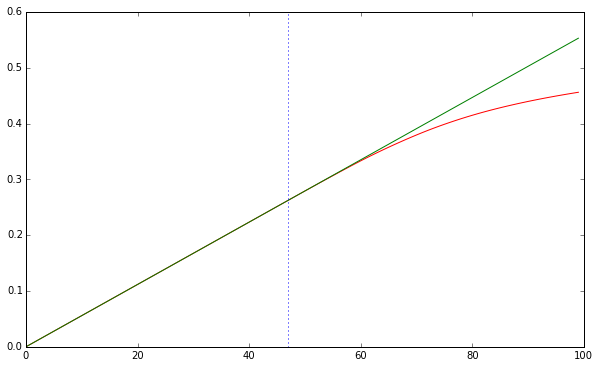

In [21]:
fig = plt.figure(figsize=(10, 6))

plt.subplot(111)
plt.plot(range(100),effective_c,'red',label = 'effective')
plt.plot(range(100),ideal_c,'green',label = 'ideal')
plt.axvline(x=47,linestyle=':')


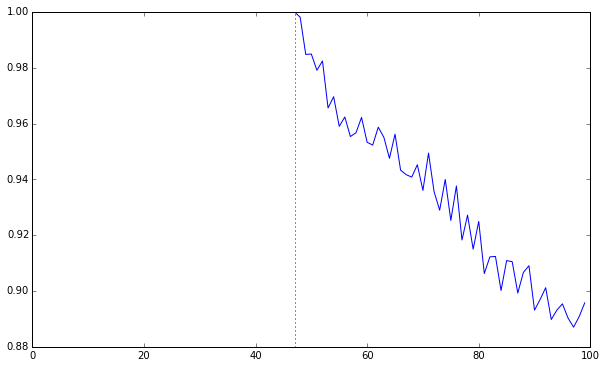

In [22]:
fig = plt.figure(figsize=(10, 6))

plt.subplot(111)
plt.plot(range(100),trigger_r,'blue',label = 'trigger')
plt.axvline(x=47,linestyle=':')

## Penetration example

C:\Users\Admin\Anaconda\lib\site-packages\IPython\kernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


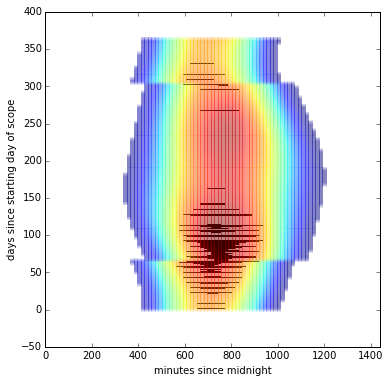

In [37]:
i = 60 #48, 50, 60, 70, 80, 90, 100
e_c, i_c, t_r = quick_penetration(i);
Ref = d.tsLocal.iloc[0].date()
x = d.tsLocal.map(lambda x: x.hour*60 + x.minute)
y = d.tsLocal.map(lambda x: (x.date()-Ref).days)

fig = plt.figure(figsize=(6, 6))

ax1 = fig.add_subplot(111)

plt.scatter(x, y, c= d['check'],\
            cmap = 'gray',edgecolors='none',marker=',',s=20, vmin=0,vmax= 1)
ax1.set_xlabel('minutes since midnight')
ax1.set_ylabel('days since starting day of scope')
ax1.set_xlim(0,1440)
#cbar = plt.colorbar(ax=ax1)
#cbar.ax.set_ylabel('load (-)')
plt.scatter(x, y, c= d['mpower'],edgecolors='none',marker=',',s=20, alpha =.1)



In [24]:
#d[d['check']==False][['tsLocal','load','netload']]

### Implementing curtailment by percent solar 

Now it is time to implement some curtailment policy. Let's do it for 50, 60, 70, 80, and 90 percent penetration.

In [25]:
#specify scope
StartScopeDate = '2014-01-01'
EndScopeDate = '2015-01-01'
StartScopeTime =  datetime.datetime.strptime(StartScopeDate,"%Y-%m-%d")
EndScopeTime =  datetime.datetime.strptime(EndScopeDate,"%Y-%m-%d")

#Generate data frame from start to end for time series
DateList = []
nxt = StartScopeTime
while nxt < EndScopeTime:
    DateList.append(nxt.date())
    nxt += datetime.timedelta(days=1)


In [26]:
threshold_trigger = [ math.floor(elem*100)/100.0 for elem in trigger_r]
#threshold_trigger
i = 90 #48, 50, 60, 70, 80, 90, 100
e_c, i_c, t_r = quick_penetration(i);
threshold = threshold_trigger[i];

C:\Users\Admin\Anaconda\lib\site-packages\IPython\kernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [27]:
Load = [0]*len(DateList)
IdealSolarEnergy = [0]*len(DateList)
EffectiveSolarEnergy = [0]*len(DateList)
CurtailedSolarEnergy = [0]*len(DateList)
for i in range(0,len(DateList)):
    #i = 100
    df = d[d.tsLocal.map(lambda x: x.date() == DateList[i])]
    IdealSolarEnergy[i] = np.sum(df['solar'])
    EffectiveSolarEnergy[i] = np.sum(df['solar'][df['check']==True])+np.sum(df['load'][df['check']==False])
    if np.sum(df['SolarRatio']> threshold)==0:
        CurtailedSolarEnergy[i] = IdealSolarEnergy[i]
    else:
        index_start = df['solar'][df['SolarRatio']>threshold].index[0]
        #index_start = np.min(df['solar'][df['SolarRatio']>threshold].index)
        index_end = df['solar'][df['SolarRatio']>threshold].index[-1]
        PowerCap = df['solar'][index_start]
        RatioCap = df['SolarRatio'][index_start]
        #CurtailedSolarEnergy[i] = np.sum(df['solar'][df.index[0]:(index_start+1)]) + PowerCap*(index_end-index_start) \
        #                                 +np.sum(df['solar'][(index_end+1):df.index[-1]])
        CurtailedSolarEnergy[i] = np.sum(df['solar'][df['SolarRatio']<threshold])+PowerCap*np.sum(df['SolarRatio']>threshold) 
                 # + RatioCap*(np.sum(df['load'][(index_start+1):(index_end+1)])) \
            #CurtailedSolarEnergy[i] = np.sum(df['solar'][df.index[0]:(index_start+1)]) \
            #                                + RatioCap*(np.sum(df['load'][(index_start+1):(index_end+1)])) \
            #                                 + np.sum(df['solar'][(index_end+1):df.index[-1]])
            #print index_start, index_end

        #EnergyCurtailment[i] = np.min(df['netload'])/1000.0
        #d['mpower']*maxload*i/100

In [28]:
#df.index

In [29]:
#index_start, index_end

In [30]:
#np.sum(df['SolarRatio']>threshold)

In [31]:
#PowerCap

In [32]:
#plt.plot(df['load'])
#plt.plot(df['solar'])
#plt.plot(PowerCap*(df['SolarRatio']>threshold))

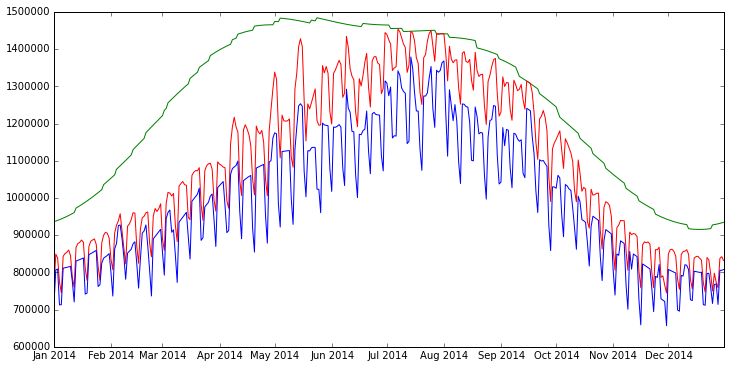

In [33]:
fig = plt.figure(figsize=(12,6))
#plt.plot(Load)
plt.plot(DateList,IdealSolarEnergy,'green')
plt.plot(DateList,EffectiveSolarEnergy,'red')
plt.plot(DateList,CurtailedSolarEnergy,'blue')

In [34]:
np.sum(IdealSolarEnergy), np.sum(EffectiveSolarEnergy), np.sum(CurtailedSolarEnergy)

(458815428.67216444, 401310286.76708919, 364475586.72027099)

In [35]:
#Collect data
penetratiion = [50, 60, 70, 80, 90]
Ideal = [254897460, 305876952, 356856444, 407835936, 458815428]
Effective = [254859270, 304157004, 346484598, 378683937, 401310286]
Curtailed = [254816469, 302780904, 338676861, 359917984, 364475586]

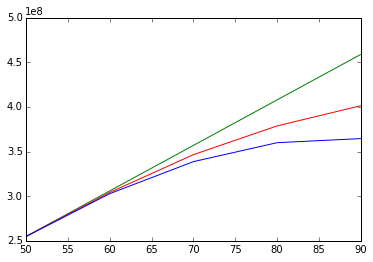

In [36]:
#fig = plt.figure(figsize=(12,6))
#plt.plot(Load)
plt.plot(penetratiion,Ideal,'green')
plt.plot(penetratiion,Effective,'red')
plt.plot(penetratiion,Curtailed,'blue')

It is worth noting that the curtailment is more difficult when the penetration is higher as the ramp rate of PV generation is higher. We need to more stringent threshold of curtailment. As the result, the total energy may drop even though we installl more solar panels.

# STOP HERE

This means, according to this bound, we can install only about 50 percent of maximum load (both 2013 and 2014). 

In [46]:
d['penetrationratio'] = d['load']/d['mpower']/np.max(d['load'])
penetrationratio = np.min(d['penetrationratio'])
#d[d['penetrationratio'] == np.min(d['penetrationratio'])]
#maximum load of the year, minimum load of the year
#np.max(d['load']), np.min(d['load'])

In [47]:
#occurence of maximum load of the year
d[d['load']==np.max(d['load'])]

,tsLocal,load,altitude,azimuth,power,numactivecomp,totalsize,s,DBW,mpower,r,expectedr,netload,check,penetrationratio
20420,2014-08-01 17:00:00,43479.84,33.516612,-90.087864,0.45855,105,743.81488,0.833725,-143,0.598757,0.765838,0.73323,17445.998884,False,1.670128


In [48]:
#occurrence of minimum load of the year
d[d['load']==np.min(d['load'])]

,tsLocal,load,altitude,azimuth,power,numactivecomp,totalsize,s,DBW,mpower,r,expectedr,netload,check,penetrationratio
5772,2014-03-02 03:00:00,17747.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17747.5,False,NaN


In [49]:
#maximum installed capacity allowed
penetrationratio*np.max(d['load'])

20819.954970640581

In [50]:
#readjust penetration and find the hitting point 
d['netload'] = -d['mpower']*penetrationratio*np.max(d['load'])
d['netload'][d['mpower'].isnull()] = 0
d['netload'] = d['netload']+ d['load']
d[d['penetrationratio'] == np.min(d['penetrationratio'])]

C:\Users\Admin\Anaconda\lib\site-packages\IPython\kernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,tsLocal,load,altitude,azimuth,power,numactivecomp,totalsize,s,DBW,mpower,r,expectedr,netload,check,penetrationratio
10513,2014-04-20 12:15:00,21625.545,66.872448,-339.133462,0.87473,91,632.886429,-0.150401,-246,1.038693,0.842144,0.835641,0,True,0.478842


In [51]:
#Look what happen at the peak load of the year
d[d['load'] == np.max(d['load'])]

,tsLocal,load,altitude,azimuth,power,numactivecomp,totalsize,s,DBW,mpower,r,expectedr,netload,check,penetrationratio
20420,2014-08-01 17:00:00,43479.84,33.516612,-90.087864,0.45855,105,743.81488,0.833725,-143,0.598757,0.765838,0.73323,31013.754574,False,1.670128


(0, 364)

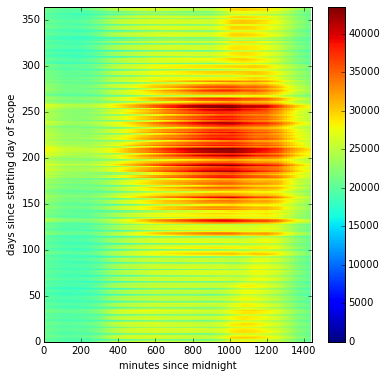

In [26]:
#For thesis
Ref = d.tsLocal.iloc[0].date()
x = d.tsLocal.map(lambda x: x.hour*60 + x.minute)
y = d.tsLocal.map(lambda x: (x.date()-Ref).days)
plt.clf()
fig = plt.figure(figsize=(6, 6))

ax1 = fig.add_subplot(111)
#plt.subplot(2, 2, 1)

#plt.title('pcolor')
# set the limits of the plot to the limits of the data
#plt.axis([x.min(), x.max(), y.min(), y.max()])
#plt.colorbar()
maxload = np.max(d['load'])
#plt.pcolor(x, y, c=d['load'], cmap='RdBu', vmin=-maxload,vmax= maxload)
#color adjust with white = 0
#plt.scatter(x, y, c= d['load'], cmap = 'RdBu',edgecolors='none',marker=',',s=20, vmin=-maxload,vmax= maxload)
#color no-adjust
plt.scatter(x, y, c= d['load'],edgecolors='none',marker=',',s=20, vmin = 0, vmax = maxload)
#plt.scatter(x, y, c= d['netload'],edgecolors='none',marker=',',s=20, vmin = 0, vmax = maxload)
ax1.set_xlabel('minutes since midnight')
ax1.set_ylabel('days since starting day of scope')
cbar = plt.colorbar(ax=ax1)
#cbar.ax.set_ylabel('load (GW)')
ax1.set_xlim(0,1440)
ax1.set_ylim(np.min(y),np.max(y))


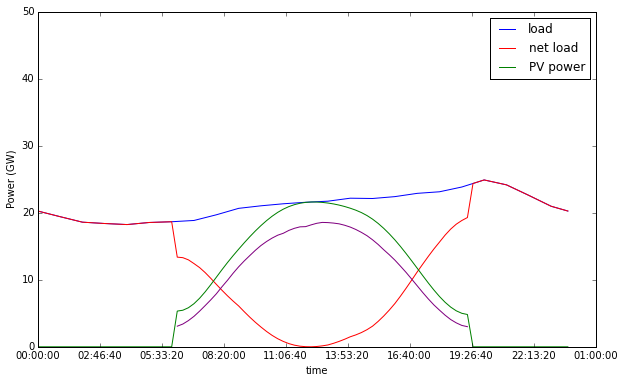

In [27]:
#for the conference paper
fig = plt.figure(figsize=(10, 6))

plt.subplot(111)
#DateOfInterest = datetime.date(2013,xx,xx)
DateOfInterest = datetime.date(2014,4,20)
#DateOfInterest = datetime.date(2014,8,1)
df2 = d[d.tsLocal.map(lambda x: x.date() == DateOfInterest)]
plt.plot(df2.tsLocal.map(lambda x: x.time()),df2['load']/1000.0,'blue',label = 'load')
plt.plot(df2.tsLocal.map(lambda x: x.time()),df2['netload']/1000.0,'red',label = 'net load')
plt.plot(df2.tsLocal.map(lambda x: x.time()),(df2['load']-df2['netload'])/1000.0,'green', label = 'PV power')
plt.plot(df2.tsLocal.map(lambda x: x.time()),(df2['power']*penetrationratio*np.max(d['load']))/1000.0,'purple')
#plt.plot(df2.tsLocal.map(lambda x: x.time()),(df2['load']-df2['power']*penetrationratio*np.max(d['load']))/1000.0,'green')
plt.ylim(0,50)
plt.ylabel("Power (GW)")
plt.legend()


In [28]:
dsummary = pd.read_csv(outputDir+'/fitsummary.csv')
dsummary.Date = dsummary.Date.map(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d").date())

In [29]:
dsummary.Date[0] #This is Tuesday. So Sunday start with index 5

datetime.date(2013, 1, 1)

In [30]:
MinNetLoad = [0]*len(dsummary.Date)
for i in range(0,len(dsummary.Date)):
    df = d[d.tsLocal.map(lambda x: x.date() == dsummary.Date[i])]
    MinNetLoad[i] = np.min(df['netload'])/1000.0

In [31]:
MaxLoad = [0]*len(dsummary.Date)
for i in range(0,len(dsummary.Date)):
    df = d[d.tsLocal.map(lambda x: x.date() == dsummary.Date[i])]
    MaxLoad[i] = np.max(df['load'])/1000.0

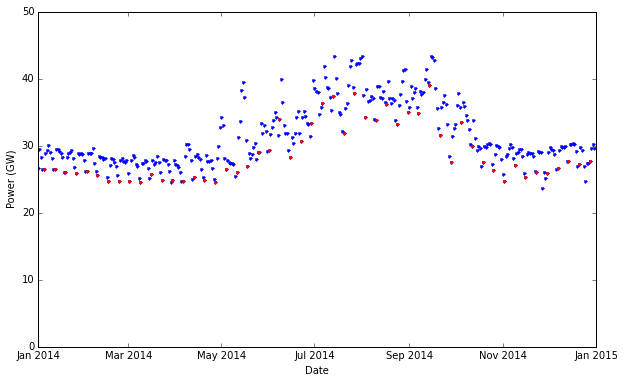

In [32]:
#For Conference
fig = plt.figure(figsize=(10,6))
ax1  = fig.add_subplot(111)

#ax1.plot(dsummary.Date, MinNetLoad, 'b.')
ax1.plot(dsummary.Date, MaxLoad, 'b.')
#ax1.plot(dsummary.Date[5:(365*2):7], MinNetLoad[5:(365*2):7], 'r.')
ax1.plot(dsummary.Date[5:(365*2):7], MaxLoad[5:(365*2):7], 'r.')
ax1.set_xlim([datetime.datetime.strptime("2014-01-01" +" 00:00:00","%Y-%m-%d %H:%M:%S").date(),\
              datetime.datetime.strptime("2015-01-01" +" 00:00:00","%Y-%m-%d %H:%M:%S").date()])
#ax1.set_xlabel('day before winter solstice')
# Make the y-axis label and tick labels match the line color.
ax1.set_ylabel('Power (GW)')#, color='b')
ax1.set_ylim([0,50])
ax1.set_xlabel('Date')

(0, 43479.839999999997)

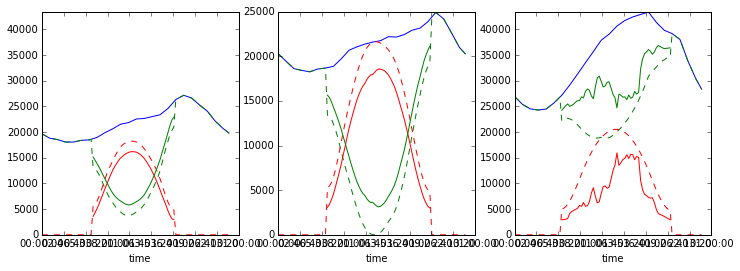

In [33]:
fig = plt.figure(figsize=(4*3, 4*1))

plt.subplot(131)
#DateOfInterest = datetime.date(2013,xx,xx)
DateOfInterest = datetime.date(2014,11,9)
df2 = d[d.tsLocal.map(lambda x: x.date() == DateOfInterest)]
plt.plot(df2.tsLocal.map(lambda x: x.time()),df2['load'],'blue')
plt.plot(df2.tsLocal.map(lambda x: x.time()),df2['netload'],'green',linestyle='--')
plt.plot(df2.tsLocal.map(lambda x: x.time()),df2['load']-df2['netload'],'red',linestyle='--')
plt.plot(df2.tsLocal.map(lambda x: x.time()),df2['power']*penetrationratio*np.max(d['load']),'red')
plt.plot(df2.tsLocal.map(lambda x: x.time()),df2['load']-df2['power']*penetrationratio*np.max(d['load']),'green')
plt.ylim(0,np.max(d['load']))

plt.subplot(132)
#DateOfInterest = datetime.date(2013,3,24)
DateOfInterest = datetime.date(2014,4,20)
df1 = d[d.tsLocal.map(lambda x: x.date() == DateOfInterest)]
plt.plot(df1.tsLocal.map(lambda x: x.time()),df1['load'],'blue')
plt.plot(df1.tsLocal.map(lambda x: x.time()),df1['netload'],'green',linestyle='--')
plt.plot(df1.tsLocal.map(lambda x: x.time()),df1['load']-df1['netload'],'red',linestyle='--')
plt.plot(df1.tsLocal.map(lambda x: x.time()),df1['power']*penetrationratio*np.max(d['load']),'red')
plt.plot(df1.tsLocal.map(lambda x: x.time()),df1['load']-df1['power']*penetrationratio*np.max(d['load']),'green')
#plt.plot(DailyData.Date,DailyData['mE'],color='red',linestyle='--')
#plt.plot(DailyData.Date,DailyData['E2'],color='red')
#plt.ylim(0,np.max(d['load']))

plt.subplot(133)
#DateOfInterest = datetime.date(2013,7,2)
DateOfInterest = datetime.date(2014,7,14)
df2 = d[d.tsLocal.map(lambda x: x.date() == DateOfInterest)]
plt.plot(df2.tsLocal.map(lambda x: x.time()),df2['load'],'blue')
plt.plot(df2.tsLocal.map(lambda x: x.time()),df2['netload'],'green',linestyle='--')
plt.plot(df2.tsLocal.map(lambda x: x.time()),df2['load']-df2['netload'],'red',linestyle='--')
plt.plot(df2.tsLocal.map(lambda x: x.time()),df2['power']*penetrationratio*np.max(d['load']),'red')
plt.plot(df2.tsLocal.map(lambda x: x.time()),df2['load']-df2['power']*penetrationratio*np.max(d['load']),'green')
plt.ylim(0,np.max(d['load']))

In [34]:
#[1-np.sum(df1['netload'])/np.sum(df1['load']),1-np.sum(df2['netload'])/np.sum(df2['load'])]

In [35]:
#Energy consumption, generation, max generation in MWhr at maximum penetration 
total_energy_consumption = np.sum(d['load'])/4
total_energy_max_generation = (np.sum(d['load'])-np.sum(d['netload']))/4
total_energy_generation = np.sum(d['power'])*penetrationratio*np.max(d['load'])/4
max_energy_penetration = 1-np.sum(d['netload'])/np.sum(d['load'])
actual_energy_penetration = total_energy_generation/total_energy_consumption

[total_energy_consumption,
total_energy_generation,
total_energy_max_generation,
actual_energy_penetration,
max_energy_penetration]

[228148151.68875,
 48167431.263584368,
 61027750.413816422,
 0.21112347791139044,
 0.26749175902627176]

Let's summary some important numbers figures (see detail below):

Load used: total of CAISO

In 2014:

Maximum load of the year is 43480 MW which occurs on 2014/8/1, 17:00:00

Maximum PV installed capacity allowed by non-negative net load any time of the year is 21626 MW (about 48 percent of maximum load). The constraint is tightened on 2014-04-20 12:15:00

Total energy consumption of the year is about 228 TWh

With maximum PV installed capacity and perfect weather, energy generation of the year is about 61 TWh (about 26.7 percent of total energy consumption). Under weather appeared in 2014, energy generation of the year is about 48 TWh (about 21.1 percent to maximum energy generation, which is quite optimistic since it is in CA and in-land)


Note:

1. Ramp rate can be a concern

2. Maximum power installed is about 48 percent of peak load of the year. Energy contribution for solar is even less than this 50 percent estimate since solar is not operating at night.

3. In this analysis, we assume PV panels perform perfectly. If we assume less optimistic situation, for examples, PV panels peform 90 percent uniformly, we may add more PVs so that the resulting PV power hits the demand bound again. 

4. This is upper bounded and optimistic because

(1) Most substations do not allow running backward but our model allows the power transfer freely

(2) We have ignored transmission constraints

(3) Some residential and urban commercial areas have mismatches beween demanad and possily supply

In [36]:
#Daily Information
#select data to analyze

DateList = list(set(d.tsLocal.map(lambda x: x.date())))
#set up date list and summary table
DateList.sort()

DailyData = pd.DataFrame(float('NaN'), index = np.arange(len(DateList)), \
                        columns = ['load','netload','E1','E2','mE'])
DailyData['Date']=DateList

In [37]:
#Loop for ratio calculation
for i in range(0,DailyData.shape[0]):
    d_series = d[d.tsLocal.map(lambda x: x.date()) == DailyData.Date[i]]
    DailyData.loc[i,'load'] = np.sum(d_series['load'])*15/60
    DailyData.loc[i,'netload'] = np.sum(d_series['netload'])*15/60
    DailyData.loc[i,'E1'] = np.sum(d_series['load']-d_series['netload'])*15/60
    DailyData.loc[i,'E2'] = np.sum(d_series['power'].dropna())*penetrationratio*np.max(d['load'])*15/60
    DailyData.loc[i,'mE'] = np.sum(d_series['mpower'].dropna())*penetrationratio*np.max(d['load'])*15/60
    

In [38]:
#DailyData

(0, 827344.13874999993)

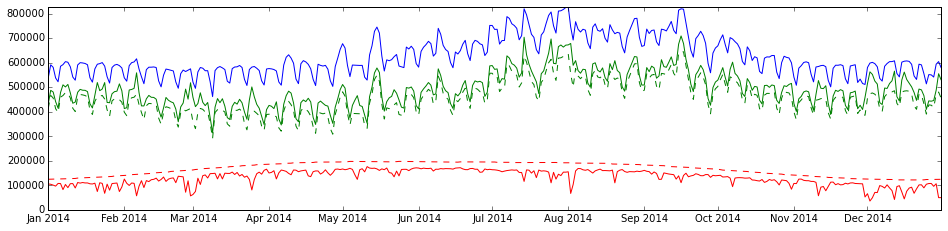

In [39]:
#plt.plot(VariabilityTable['E'],VariabilityTable['V'],'.')
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(211)
plt.plot(DailyData.Date,DailyData['load'],color='blue')
plt.plot(DailyData.Date,DailyData['mE'],color='red',linestyle='--')
plt.plot(DailyData.Date,DailyData['E2'],color='red')
plt.plot(DailyData.Date,DailyData['netload'],color='green',linestyle='--')
plt.plot(DailyData.Date,DailyData['load']-DailyData['E2'],color='green')
#d_series.plot(ylim=[0,1],style='.')
#plt.vlines(x = RatioTable.index, ymin= RatioTable['day_mean']- RatioTable['day_d'], ymax = RatioTable['day_mean']+RatioTable['day_d'])
#plt.ylabel('mean of previous day ratio')
plt.ylim(0,np.max(DailyData['load']))

#ax1 = fig.add_subplot(212)
#plt.plot(RatioTable.index,RatioTable['week_mean'],'.')
#d_series.plot(ylim=[0,1],style='.')
#plt.vlines(x = RatioTable.index, ymin= RatioTable['week_mean']-RatioTable['week_d'], ymax = RatioTable['week_mean']+RatioTable['week_d'])
#plt.ylabel('mean of week day ratio')
#plt.ylim(0,1.5)